# Определение перспективного тарифа для телеком-компании

Заказчик - федеральный оператор сотовой связи.

Он предлагает клиентам два тарифных плана: «Смарт» и «Ультра».

Коммерческий департамент планирует скорректировать рекламный бюджет и хочет понять, какой тариф приносит больше денег.

Необходимо провести предварительный анализ тарифов на выборке из пятисот клиентов за 2018 год: проанализировать их поведение и сделать вывод о более подходящем тарифе.

## Описание тарифов

Тариф «Смарт»
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: 
    *	минута разговора: 3 рубля
    *	сообщение: 3 рубля
    *	1 Гб интернет-трафика: 200 рублей
    
Тариф «Ультра»
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: 
    *	минута разговора: 1 рубль
    *	сообщение: 1 рубль
    *	1 Гб интернет-трафика: 150 рублей
    
Примечание: 
* Тарифы предполагают округление секунд до минут, а мегабайтов — до гигабайт.
* Каждый звонок округляется отдельно, даже если он длился всего 1 секунду, будет засчитан как 1 минута.
* Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Описание данных
Таблица users (информация о пользователях):
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

Таблица calls (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Примечание. Если объединение таблиц командой merge приводит к ошибке dead kernell, примените join.

## Шаг 1. Загрузка файлов с данными и изучение общей информации

In [1]:
# загружаем необходимые библиотеки и определяем пространства имён
import pandas as pd
import math
import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from functools import reduce
idx = pd.IndexSlice

#включим отображение всех столбцов таблиц и округлим числа до сотых
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

# загружаем файл с данными
try:
    df_calls = pd.read_csv('datasets/data_07/calls.csv') # locally hosted datafile ## , sep='\t'
except:
    df_calls = pd.read_csv('/datasets/calls.csv') # Yandex-hosted datafile  ## , sep='\t'

# общий анализ структуры и состава загруженного файла
df_calls.info()
display(df_calls.sample(10))
display(df_calls.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
37043,1093_321,2018-11-17,1.53,1093
168999,1416_166,2018-11-19,5.18,1416
59640,1149_158,2018-06-02,16.47,1149
193848,1476_145,2018-09-24,17.34,1476
41026,1101_69,2018-12-04,2.97,1101
173424,1428_113,2018-10-21,1.82,1428
46278,1116_8,2018-06-25,4.01,1116
72893,1183_257,2018-10-21,10.56,1183
155055,1382_838,2018-11-15,0.00,1382
178086,1441_33,2018-12-05,4.88,1441


,duration,user_id
count,"202,607.00","202,607.00"
mean,6.76,"1,253.94"
std,5.84,144.72
min,0.00,"1,000.00"
25%,1.30,"1,126.00"
50%,6.00,"1,260.00"
75%,10.70,"1,379.00"
max,38.00,"1,499.00"


In [2]:
# загружаем файл с данными
try:
    df_internet = pd.read_csv('datasets/data_07/internet.csv') # locally hosted datafile ## , sep='\t'
except:
    df_internet = pd.read_csv('/datasets/internet.csv') # Yandex-hosted datafile  ## , sep='\t'

# общий анализ структуры и состава загруженного файла
df_internet.info()
display(df_internet.sample(10))
display(df_internet.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
83848,83848,1284_202,576.81,2018-05-11,1284
107391,107391,1364_89,348.34,2018-12-19,1364
56379,56379,1188_185,256.11,2018-10-12,1188
84630,84630,1287_185,349.36,2018-11-11,1287
7703,7703,1027_30,394.92,2018-09-07,1027
124033,124033,1417_67,417.76,2018-12-01,1417
30029,30029,1105_97,837.54,2018-12-04,1105
58276,58276,1196_274,855.19,2018-06-07,1196
120577,120577,1407_109,525.39,2018-09-11,1407
73817,73817,1248_386,403.61,2018-09-23,1248


,Unnamed: 0,mb_used,user_id
count,"149,396.00","149,396.00","149,396.00"
mean,"74,697.50",370.19,"1,252.10"
std,"43,127.05",278.30,144.05
min,0.00,0.00,"1,000.00"
25%,"37,348.75",138.19,"1,130.00"
50%,"74,697.50",348.01,"1,251.00"
75%,"112,046.25",559.55,"1,380.00"
max,"149,395.00","1,724.83","1,499.00"


In [3]:
# загружаем файл с данными
try:
    df_messages = pd.read_csv('datasets/data_07/messages.csv') # locally hosted datafile ## , sep='\t'
except:
    df_messages = pd.read_csv('/datasets/messages.csv') # Yandex-hosted datafile  ## , sep='\t'

# общий анализ структуры и состава загруженного файла
df_messages.info()
display(df_messages.sample(10))
display(df_messages.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
19904,1088_194,2018-06-11,1088
41129,1174_474,2018-11-24,1174
111671,1452_60,2018-07-29,1452
37499,1164_168,2018-09-17,1164
91385,1379_71,2018-11-18,1379
63577,1277_254,2018-09-05,1277
15339,1066_81,2018-09-12,1066
29951,1130_326,2018-12-30,1130
109532,1440_473,2018-09-10,1440
17255,1076_404,2018-03-26,1076


,user_id
count,"123,036.00"
mean,"1,256.99"
std,143.52
min,"1,000.00"
25%,"1,134.00"
50%,"1,271.00"
75%,"1,381.00"
max,"1,499.00"


In [4]:
# загружаем файл с данными
try:
    df_tariffs = pd.read_csv('datasets/data_07/tariffs.csv') # locally hosted datafile ## , sep='\t'
except:
    df_tariffs = pd.read_csv('/datasets/tariffs.csv') # Yandex-hosted datafile  ## , sep='\t'

# общий анализ структуры и состава загруженного файла
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [5]:
# загружаем файл с данными
try:
    df_users = pd.read_csv('datasets/data_07/users.csv') # locally hosted datafile ## , sep='\t'
except:
    df_users = pd.read_csv('/datasets/users.csv') # Yandex-hosted datafile  ## , sep='\t'

# общий анализ структуры и состава загруженного файла
df_users.info()
display(df_users.sample(10))
display(df_users.describe())
print(df_users['city'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
381,1381,64,NaN,Москва,Тамара,Серебрякова,2018-01-13,ultra
425,1425,51,NaN,Пермь,Вадим,Фомин,2018-02-27,smart
93,1093,73,NaN,Санкт-Петербург,Вероника,Лапина,2018-06-29,smart
309,1309,28,NaN,Казань,Юлия,Касьянова,2018-10-05,ultra
467,1467,66,NaN,Киров,Исак,Александрюк,2018-11-24,ultra
146,1146,72,NaN,Санкт-Петербург,Владислав,Никонов,2018-05-25,smart
475,1475,40,NaN,Новокузнецк,Лидия,Фадеева,2018-01-09,smart
413,1413,37,NaN,Новосибирск,Леон,Фролов,2018-08-19,smart
287,1287,39,NaN,Севастополь,Вениамин,Мишин,2018-09-23,smart
113,1113,52,NaN,Чита,Харитон,Булгаков,2018-01-24,smart


,user_id,age
count,500.00,500.00
mean,"1,249.50",46.59
std,144.48,16.67
min,"1,000.00",18.00
25%,"1,124.75",32.00
50%,"1,249.50",46.00
75%,"1,374.25",62.00
max,"1,499.00",75.00


Москва             99
Санкт-Петербург    39
Новосибирск        16
Омск               14
Казань             14
                   ..
Нижневартовск       1
Архангельск         1
Химки               1
Подольск            1
Иваново             1
Name: city, Length: 76, dtype: int64


## Выводы по шагу 1

<div class="alert alert-block alert-info">
</div>

* Все таблицы успешно загружены, разделители и ключи понятны
* В данных нет пропусков (единственная неполная колонка - users.churn_date, т.е. дата завершения пользования тарифом. его логика понятна).
* Очевидных искажений и выбросов в данных не наблюдается
* Необходимо преобразовать тип данных у столбцов с датой
* Необходимо округлить значения минут разговора и мегабайт использованного трафика в большую сторону, так как тарифы считаются по минутам и мегабайтам.
* После создания сводной таблицы по звонкам, сообщениям и интернет-трафику клиентов необходимо проверить появление пропущенных значений и заменить их на нули.

## Шаг 2. Подготовка данных
Необходимо выполнить:
* Приведение данных к нужным типам;
* Поиск и исправление ошибок в данных, если они есть.

Нулевую продолжительность имеют пропущенные звонки, их не нужно удалять. 

Для каждого пользователя вычислить:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножить на значение из тарифного плана; прибавить абонентскую плату, соответствующую тарифному плану).

### 2.1 Приведение данных к нужным типам

In [6]:
#заменим тип данных дат со строкового на datetime там, где это необходимо
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')

df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')

###===================================================
### Перенесено из 2.2.1 для округления интернета v2
#добавим столбец со значением месяца к звонкам, сообщениям и траффику
df_calls['month'] = df_calls['call_date'].dt.month
df_messages['month'] = df_messages['message_date'].dt.month
df_internet['month'] = df_internet['session_date'].dt.month


### Округление по тарифам v2
#округлим значения в большую сторону по логике расчёта тарифа (тариф - поминутный с округлением в большую сторону с первой секунды)
df_calls['duration'] = df_calls['duration'].apply(np.ceil)

#Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.
#Перед округлением будем укрупнять до месяца+пользователя с максимальным сохранением остальной структуры данных
# [user_id][month][mb_used]

### создадим сгруппирвоанную копию таблицы для сборки общей таблицы и анализа
dfg_internet = df_internet.groupby(by=["user_id", "month"], as_index=False)["mb_used"].sum()

###display(dfg_internet)

#округлим значения в большую сторону по логике расчёта тарифа (тариф - поГИГАбайтный с округлением в большую сторону с первого байта)
##dfg_internet['mb_used'] = dfg_internet['mb_used'].apply(np.ceil)
# получаем гигабайты и округляем их вверх
# расчёт будем вести в округлённых мегабайтах - чтобы не переписывать весь код расчётов ниже
dfg_internet["mb_used"] = np.ceil(dfg_internet["mb_used"]/1024)*1024

display(dfg_internet)

###===================================================


#заменим тип полей на целочисленный там, где это необходимо
df_calls['id'] = df_calls['id'].astype('int')
df_calls['duration'] = df_calls['duration'].astype('int')
df_messages['id'] = df_messages['id'].astype('int')
df_internet['id'] = df_internet['id'].astype('int')
df_internet['mb_used'] = df_internet['mb_used'].astype('int')
dfg_internet['mb_used'] = dfg_internet['mb_used'].astype('int')

,user_id,month,mb_used
0,1000,5,"3,072.00"
1,1000,6,"23,552.00"
2,1000,7,"14,336.00"
3,1000,8,"14,336.00"
4,1000,9,"15,360.00"
...,...,...,...
3198,1498,10,"21,504.00"
3199,1499,9,"2,048.00"
3200,1499,10,"18,432.00"
3201,1499,11,"18,432.00"


### 2.2 Анализ данных и исправление ошибок

#### 2.2.1 Звонки

In [7]:
#выведем число звонков с нулевой длительностью
print('Число звонков с нулевой длительностью:', df_calls.loc[df_calls['duration'] == 0, 'duration'].value_counts()[0])

Число звонков с нулевой длительностью: 39613


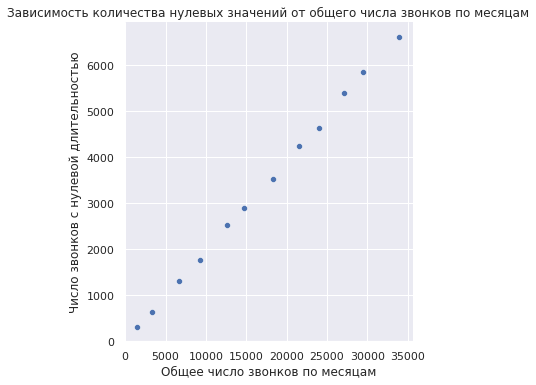

In [8]:
### Заремарил --> перенос в 2.1 для округления интернета v2
#добавим столбец со значением месяца к звонкам и сообщениям
###df_calls['month'] = df_calls['call_date'].dt.month
###df_messages['month'] = df_messages['message_date'].dt.month

#построим график зависимости количества нулевых значений от общего числа звонков за каждый месяц
df_calls.loc[df_calls['duration'] == 0, 'zero_count'] = 1
zero_calls = df_calls.pivot_table(index='month', values=['id', 'zero_count'], aggfunc='count')
zero_calls['zero_ratio'] = round(zero_calls['zero_count'] / zero_calls['id'], 3)

sns.relplot(x='id', y='zero_count', data=zero_calls, color='C0')
plt.xlabel('Общее число звонков по месяцам')
plt.ylabel('Число звонков с нулевой длительностью')
_ = plt.title('Зависимость количества нулевых значений от общего числа звонков по месяцам')

Число звонков с нулевой длительностью линейно растёт со временем, что соответсвует методической сути явления.

Какая-либо обработка или замена нулевых значений не требуется.

#### 2.2.1 Интернет-сессии

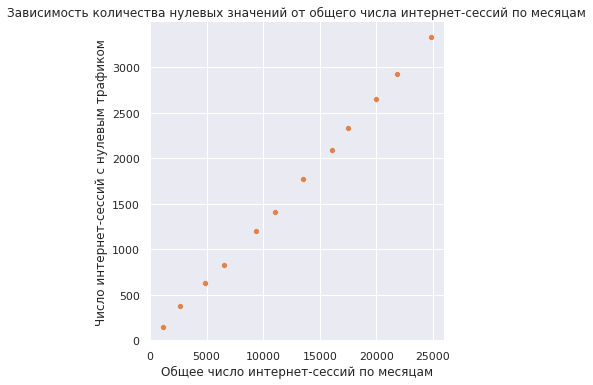

In [10]:
### Заремарил --> перенос в 2.1 для округления интернета v2
#добавим столбец со значением месяца
###df_internet['month'] = df_internet['session_date'].dt.month

#построим график зависимости количества нулевых значений от общего числа Интернет-сессий за каждый месяц
df_internet.loc[df_internet['mb_used'] == 0, 'zero_count'] = 1
zero_mb = df_internet.pivot_table(index='month', values=['id', 'zero_count'], aggfunc='count')
zero_mb['zero_ratio'] = round(zero_mb['zero_count'] / zero_mb['id'], 3)

sns.relplot(x='id', y='zero_count', data=zero_mb,  color='C1')
plt.xlabel('Общее число интернет-сессий по месяцам')
plt.ylabel('Число интернет-сессий с нулевым трафиком')
_ = plt.title('Зависимость количества нулевых значений от общего числа интернет-сессий по месяцам')

Объём нулевого траффика также линейно растёт со временем, что соответсвует методической сути явления.

Какая-либо обработка или замена нулевых значений не требуется.

### 2.3 Расчёт дополнительных данных по пользователям
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [12]:
#сводная таблица по звонкам
df_calls_grouped = df_calls.pivot_table(values=['id', 'duration'], 
                       index=['user_id', 'month'], 
                       aggfunc={'id': lambda x: len(x.unique()), 'duration': 'sum'})
df_calls_grouped.columns = ['duration', 'calls']

#сводная таблица по сообщениям
df_messages_grouped = df_messages.pivot_table(values='id', 
                       index=['user_id', 'month'], 
                       aggfunc={'id': lambda x: len(x.unique())})
df_messages_grouped.columns = ['messages']

#сводная таблица по интернет-трафику
df_internet_grouped = dfg_internet.pivot_table(values='mb_used', 
                       index=['user_id', 'month'], 
                       aggfunc={'mb_used': 'sum'})
df_internet_grouped.columns = ['mb_used']

#объединим три сводные таблицы в одну
dataframes = [df_calls_grouped, df_messages_grouped, df_internet_grouped]
df_grouped_data = reduce(lambda left,right: pd.merge(left,right,on=['user_id', 'month'], how='outer'), dataframes)
display(df_grouped_data.head(10))

duration  calls  messages   mb_used
user_id month                                     
1000    5        159.00  22.00     22.00  3,072.00
        6        172.00  43.00     60.00 23,552.00
        7        340.00  47.00     75.00 14,336.00
        8        408.00  52.00     81.00 14,336.00
        9        466.00  58.00     57.00 15,360.00
        10       350.00  57.00     73.00 15,360.00
        11       338.00  43.00     58.00 15,360.00
        12       333.00  46.00     70.00 10,240.00
1001    11       430.00  59.00       NaN 18,432.00
        12       414.00  63.00       NaN 14,336.00

In [13]:
#добавим каждому пользователю наименование используемого им тарифа
for user in df_grouped_data.index:
    user_data = df_users.loc[df_users["user_id"] == user[0], ['city','tariff']]
    #print(user_data)
    df_grouped_data.loc[user, 'tariff'] = user_data['tariff'].iat[0]
    df_grouped_data.loc[user, 'city'] = user_data['city'].iat[0]
    
#display(df_grouped_data)

## Копируем в таблицу сразу тариф и город
#dfu_data = df_users[['user_id','city','tariff']]

#df_grouped_data = df_grouped_data.merge(dfu_data ,how='left', on='user_id', suffixes=('', ''))
#display(df_grouped_data)

#заменим пропущенные значения на нули
df_grouped_data.loc[df_grouped_data['duration'].isna(), 'duration'] = 0
df_grouped_data.loc[df_grouped_data['messages'].isna(), 'messages'] = 0
df_grouped_data.loc[df_grouped_data['mb_used'].isna(), 'mb_used'] = 0

#напишем функцию подсчета выручки с каждого пользователя в месяц
def get_user_revenue(row):
    messages = row['messages']
    mb_used = row['mb_used']
    tariff = row['tariff']
    duration = row['duration']
    calls = row['calls']
    
    if tariff == 'smart':
        extra_duration = duration - df_tariffs.loc[0, 'minutes_included']
        extra_mb = mb_used - df_tariffs.loc[0, 'mb_per_month_included']
        extra_messages = messages - df_tariffs.loc[0, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (df_tariffs.loc[0, 'rub_per_message'] * extra_messages + 
                   (df_tariffs.loc[0, 'rub_per_gb'] / 1024) * extra_mb + 
                   df_tariffs.loc[0, 'rub_per_minute'] * extra_duration + 
                   df_tariffs.loc[0, 'rub_monthly_fee']
                  ) 
    else:
        extra_duration = duration - df_tariffs.loc[1, 'minutes_included']
        extra_mb = mb_used - df_tariffs.loc[1, 'mb_per_month_included']
        extra_messages = messages - df_tariffs.loc[1, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (df_tariffs.loc[1, 'rub_per_message'] * extra_messages + 
                   (df_tariffs.loc[1, 'rub_per_gb'] / 1024) * extra_mb + 
                   df_tariffs.loc[1, 'rub_per_minute'] * extra_duration + 
                   df_tariffs.loc[1, 'rub_monthly_fee']
                  )

df_grouped_data['revenue'] = df_grouped_data.apply(get_user_revenue, axis=1)
display(df_grouped_data.head(10))

duration  calls  messages   mb_used tariff       city  revenue
user_id month                                                                
1000    5        159.00  22.00     22.00  3,072.00  ultra  Краснодар 1,950.00
        6        172.00  43.00     60.00 23,552.00  ultra  Краснодар 1,950.00
        7        340.00  47.00     75.00 14,336.00  ultra  Краснодар 1,950.00
        8        408.00  52.00     81.00 14,336.00  ultra  Краснодар 1,950.00
        9        466.00  58.00     57.00 15,360.00  ultra  Краснодар 1,950.00
        10       350.00  57.00     73.00 15,360.00  ultra  Краснодар 1,950.00
        11       338.00  43.00     58.00 15,360.00  ultra  Краснодар 1,950.00
        12       333.00  46.00     70.00 10,240.00  ultra  Краснодар 1,950.00
1001    11       430.00  59.00      0.00 18,432.00  smart     Москва 1,150.00
        12       414.00  63.00      0.00 14,336.00  smart     Москва   550.00

## Выводы по шагу 2

<div class="alert alert-block alert-info">
</div>

* Данные по пропущенным звонкам и нулевым сессиям данных соответсвуют методической сути явления и не требуют дополнительной обработки.
* В таблицы с данными по звонкам и интернет-траффику добавлена колонка с месяцем - требуется на последующих этапах.
* Проведено округление длительности звонков и интернет-траффика в большую сторону по логике тарифов.
* Для каждого пользователя вычислены:
    * количество сделанных звонков и израсходованных минут разговора по месяцам;
    * количество отправленных сообщений по месяцам;
    * объем израсходованного интернет-трафика по месяцам;
    * помесячная выручка с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

## Шаг 3. Анализ данных
Необходимо описать поведение клиентов оператора исходя из выборки:
* Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.
* Вычислить среднее количество, дисперсию и стандартное отклонение.
* Построить гистограммы, описать распределения.

### 3.1 Анализ поведения клиентов оператора по данным выборки

smart    2229
ultra     985
Name: tariff, dtype: int64


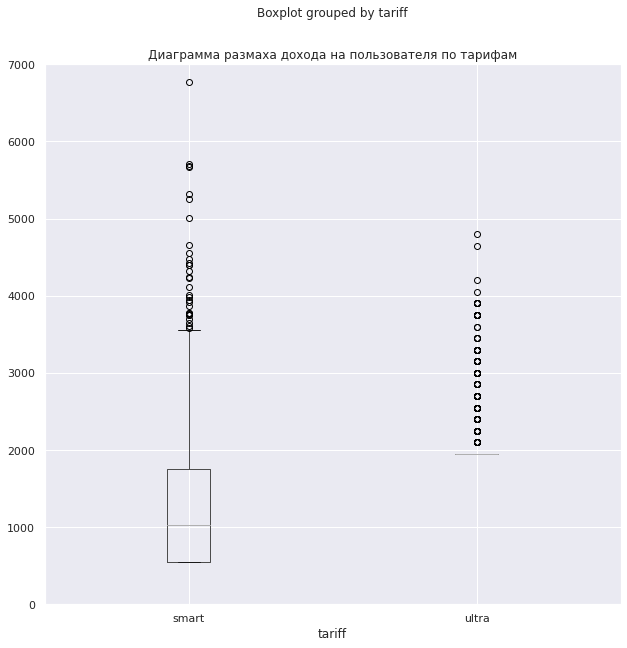

In [15]:
#посмотрим данные по тарифам
print(df_grouped_data['tariff'].value_counts())

#построим диаграмму размаха дохода на пользователя по тарифам
df_grouped_data.boxplot('revenue', by='tariff', figsize=(10,10)).set_ylim(0,7000)
plt.title('Диаграмма размаха дохода на пользователя по тарифам')
plt.show()

### 3.2 Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

In [16]:
#найдем медианные значения
median_data = df_grouped_data.pivot_table(index='user_id', values=['duration', 'messages', 'mb_used', 'revenue'], aggfunc='median')
for user_id in df_users['user_id']:
    median_data.loc[user_id, 'tariff'] = df_users.loc[df_users["user_id"] == user[0], 'tariff'].iat[0]
    
display(median_data.head())

,duration,mb_used,messages,revenue,tariff
user_id,,,,,
1000,339.00,"14,848.00",65.00,"1,950.00",ultra
1001,422.00,"16,384.00",0.00,850.00,ultra
1002,214.00,"18,432.00",11.00,"1,150.00",ultra
1003,824.00,"12,288.00",83.00,"1,950.00",ultra
1004,132.50,"18,432.00",154.50,"1,950.00",ultra


### 3.3 Среднее количество, дисперсия и стандартное отклонение

In [17]:
#найдем медиану, дисперсию и стандартное отклонение
median_data.dropna(subset=['duration'], inplace=True)
descriptive_data = df_grouped_data.pivot_table(index=['tariff'], values=['revenue', 'duration', 'mb_used', 'messages'], 
                    aggfunc={'duration': [np.mean, np.median, np.var, np.std], 
                             'mb_used': [np.mean, np.median, np.var, np.std], 
                             'messages': [np.mean, np.median, np.var, np.std],
                             'revenue': [np.mean, np.median, np.var, np.std]})
display(descriptive_data)

duration                            mb_used                      \
           mean median    std        var      mean    median       std   
tariff                                                                   
smart    417.93 422.00 190.31  36,219.32 16,720.74 17,408.00  5,884.99   
ultra    526.62 518.00 317.61 100,873.63 19,962.28 19,456.00 10,090.00   

                      messages                        revenue                  \
                  var     mean median   std      var     mean   median    std   
tariff                                                                          
smart   34,633,107.56    33.38  28.00 28.23   796.81 1,289.97 1,023.00 818.40   
ultra  101,808,012.02    49.36  38.00 47.80 2,285.27 2,070.15 1,950.00 376.19   

                   
              var  
tariff             
smart  669,785.71  
ultra  141,516.75

### 3.4 Гистограммы доходов и их распределения

#### 3.4.1 Анализ звонков и общей доходности

Text(0.5, 1.0, 'Гистограмма дохода на пользователя по тарифам Smart и Ultra')

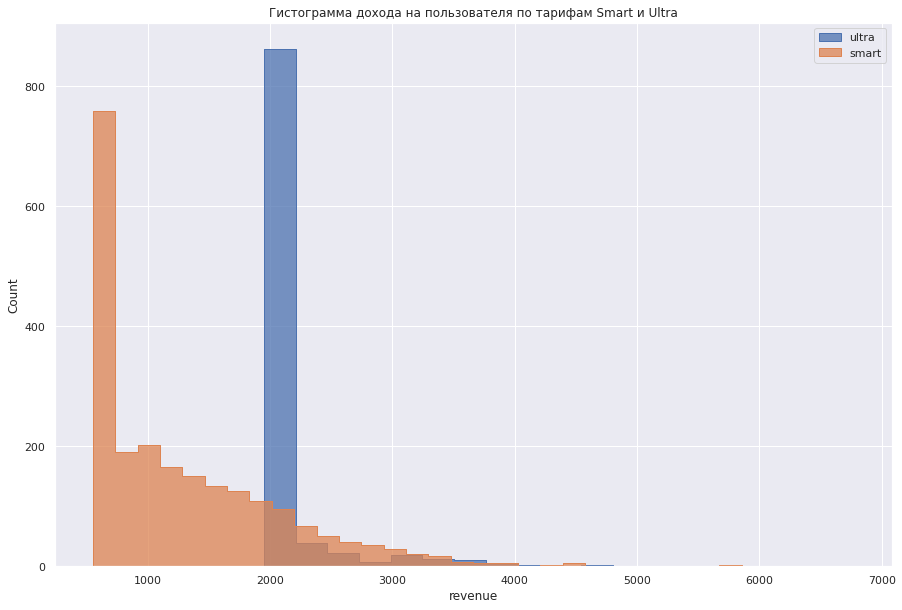

In [18]:
#гистограммы по тарифам
colors = {'ultra':'C0', 'smart':'C1'}
plt.figure(figsize=(15,10))
for tariff in ['ultra', 'smart']:
    sns.histplot(df_grouped_data.query('tariff == @tariff')['revenue'], kde=False, label=tariff, color=colors[tariff], element="step")
_ = plt.legend(['ultra', 'smart'])
plt.title('Гистограмма дохода на пользователя по тарифам Smart и Ultra')

In [19]:
#общий доход на тарифе Smart
total_revenue_smart = df_grouped_data[df_grouped_data['tariff'] == 'smart'].revenue.sum()
print("Общий доход на тарифе Smart:", total_revenue_smart)

#общий доход на тарифе Ultra
total_revenue_ultra = df_grouped_data[df_grouped_data['tariff'] == 'ultra'].revenue.sum()
print("Общий доход на тарифе Ultra:", total_revenue_ultra)

Общий доход на тарифе Smart: 2875351.0
Общий доход на тарифе Ultra: 2039100.0


Text(0.5, 1.0, 'Гистограмма распределения длительности разговоров по тарифам Smart и Ultra')

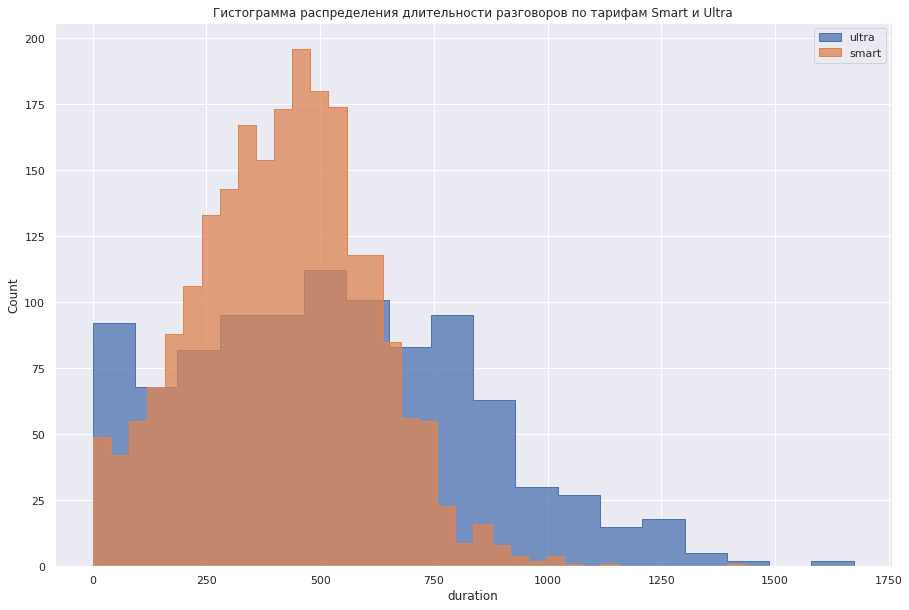

In [20]:
#гистограммы по тарифам
colors = {'ultra':'C0', 'smart':'C1'}
plt.figure(figsize=(15,10))
for tariff in ['ultra', 'smart']:
    sns.histplot(df_grouped_data.query('tariff == @tariff')['duration'], kde=False, label=tariff, color=colors[tariff], element="step")
_ = plt.legend(['ultra', 'smart'])
plt.title('Гистограмма распределения длительности разговоров по тарифам Smart и Ultra')

Пользователи тарифа Smart в среднем за месяц говорят порядка 390 минут, а на Ультре - 495 минут в месяц.
Для Smart это близко к месячному лимиту, а на Ультре у них остается огромный запас почти в 2500 минут. 
Распределение тарифа Smart скошено влево (там чаще общаются меньше среднего значения), Ultra - вправо. Люди позволяют себе поговорить.

Text(0.5, 1.0, 'Длительность звонков по месяцам на тарифах Ultra и Smart')

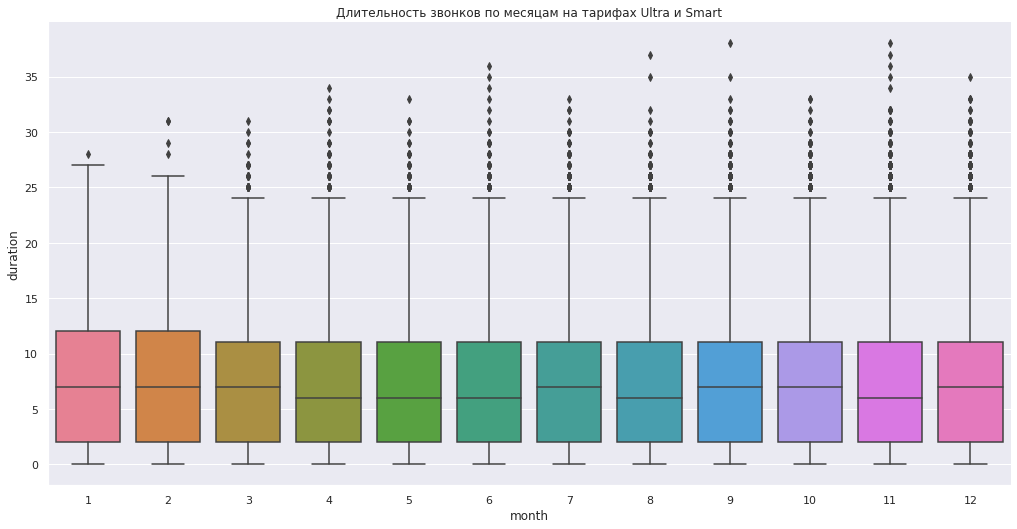

In [21]:
#поведение пользователей относительно звонков на обоих тарифах по месяцам
sns.catplot(x='month', y="duration", kind="box", data=df_calls, palette='husl', height=7, aspect=2)
plt.title('Длительность звонков по месяцам на тарифах Ultra и Smart')

Длительность звонков в январе и феврале скошена "вправо".
При этом, исходя из значений медианы, месяцами более "высокого" общения являются январь, февраль, март, июль, сентябрь, октябрь и декабрь.
Налицо имеется некая сезонность.

Для её анализа в текущем задании недостаточно ифнормации, но Мегалайну можно посоветовать изучить это направление.

#### 3.4.2 Анализ интернет-сессий

Text(0.5, 1.0, 'Гистограмма длительности интернет-сессий по тарифам Smart и Ultra')

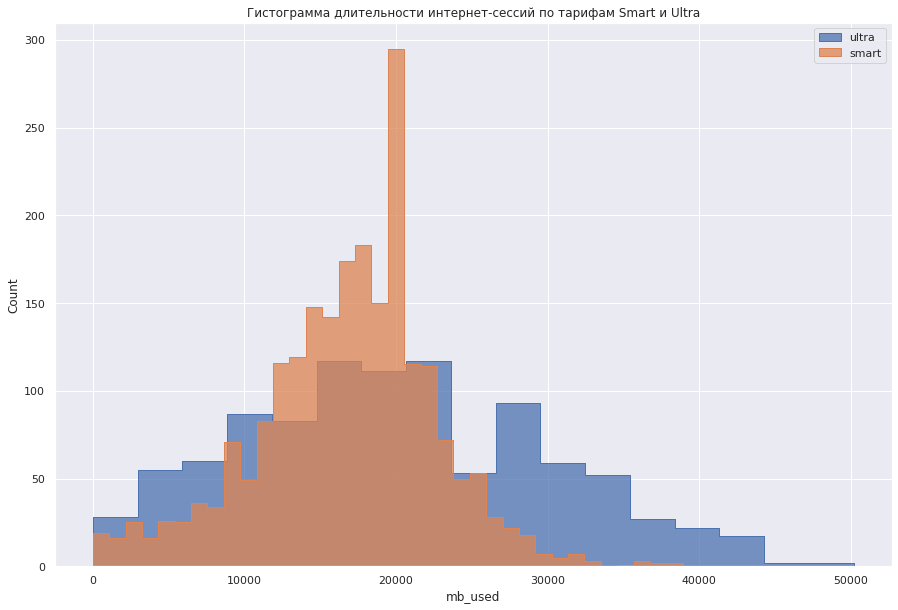

In [22]:
#гистограммы по тарифам
colors = {'ultra':'C0', 'smart':'C1'}
plt.figure(figsize=(15,10))
for tariff in ['ultra', 'smart']:
    sns.histplot(df_grouped_data.query('tariff == @tariff')['mb_used'], kde=False, label=tariff, color=colors[tariff], element="step")
_ = plt.legend(['ultra', 'smart'])
plt.title('Гистограмма длительности интернет-сессий по тарифам Smart и Ultra')

Распределения похожи на распределения звонков: на "Ультре" пользователи себя меньше ограничивают, но часто не добирают до лимитов тарифа.

В этом тарифе есть отдельная категория "тяжеловесов", стабильно выбирающая траффик сверх предоплаченного и дающая перекос распределения вправо.

На тарифе "Смарт" пользователям в стреднем не хватает предложенного объёма (17 ГБ против 15 ГБ) и они доплачивают за использование интернета.

Text(0.5, 1.0, 'Длительность интернет-сессий по месяцам на тарифах Ultra и Smart')

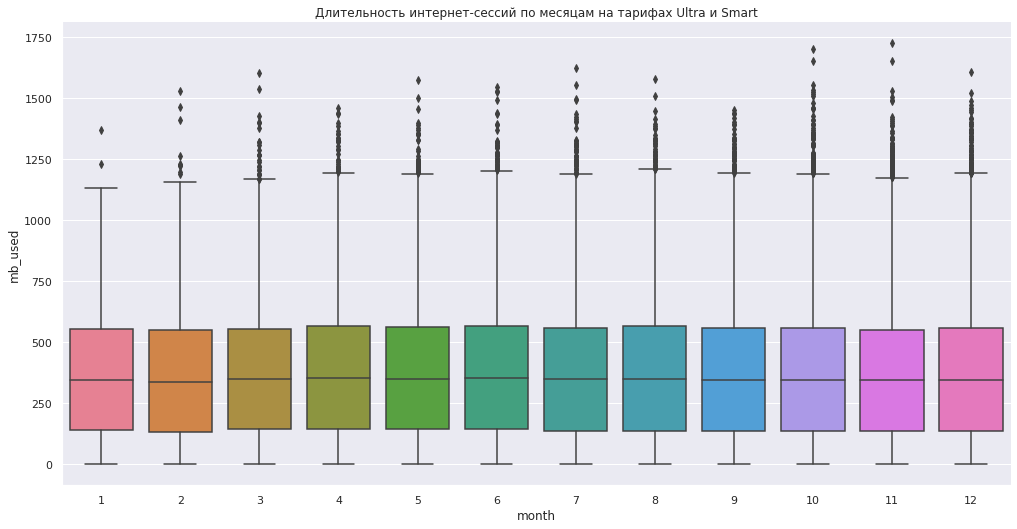

In [23]:
#поведение пользователей относительно звонков на обоих тарифах по месяцам
sns.catplot(x='month', y="mb_used", kind="box", data=df_internet, palette='husl', height=7, aspect=2)
plt.title('Длительность интернет-сессий по месяцам на тарифах Ultra и Smart')

Использование интернета пользователями по месяцам в среднем является равномерным. В отличие от звонков, здесь пользователям могут быть интересны какие-то стабильные пакетные предложения.

#### 3.4.3 Анализ sms-сообщений

Text(0.5, 1.0, 'Гистограмма смс-активности пользователей по тарифам Smart и Ultra')

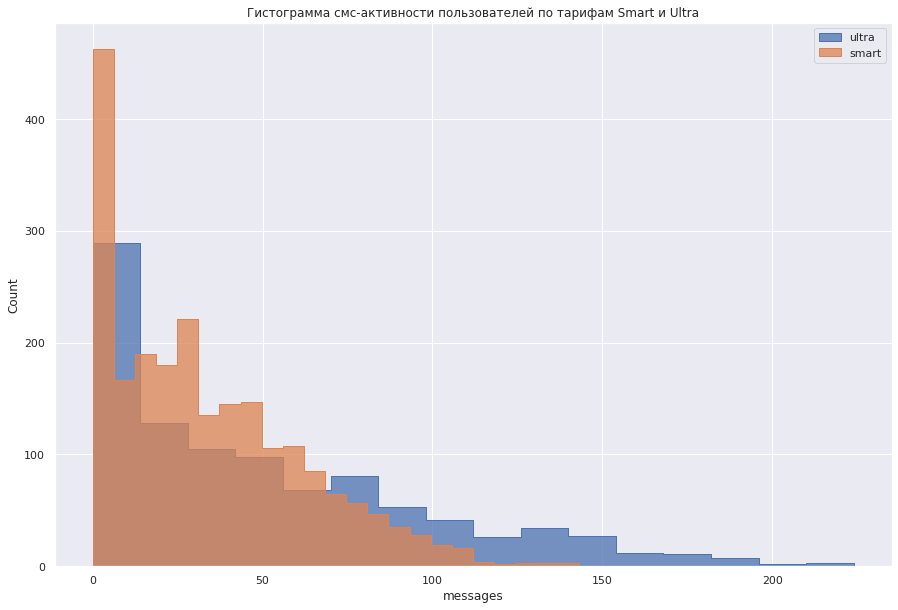

In [24]:
#гистограммы по тарифам
colors = {'ultra':'C0', 'smart':'C1'}
plt.figure(figsize=(15,10))
for tariff in ['ultra', 'smart']:
    sns.histplot(df_grouped_data.query('tariff == @tariff')['messages'], kde=False, label=tariff, color=colors[tariff], element="step")
_ = plt.legend(['ultra', 'smart'])
plt.title('Гистограмма смс-активности пользователей по тарифам Smart и Ultra')

Стандартное убывающее "геометрическое" распределение. Иногда СМС - это просто СМС.

Пользователи "Смарта" порой также выходят за лимит в 50 сообщений.

Пользователи "Ультры" активно пользуются СМС-сообщениями, при этом даже не приближаясь к лимиту.

## Выводы по шагу 3

<div class="alert alert-block alert-info">
</div>

По каждому из тарифов:
* Построена гистрграмма дохода на пользователя
* Построены гистограммы распределения длительности звонков за месяц и боксплот активности пользователей по месяцам.
* Построены гистограммы распределения объёма интернет-траффика за месяц и боксплот интернет-активности пользователей по месяцам.

Выводы:
* Дисперсия на тарифе "Смарт" ограничена лимитом тарифа, при этом пользователи по всем параметрам выходят за эти пределы. Тариф "подстригает" тех, кто любит экономить и порой не может уложиться в лимит.
* Пользователи тарифа "Ультра", наоборот, склонны к размеренности и готовы платить за предсказуемое использование сразу большую сумму;

In [25]:
#ревьюер_код_ит
ultra = df_grouped_data.query('tariff == "ultra"')
smart = df_grouped_data.query('tariff == "smart"')

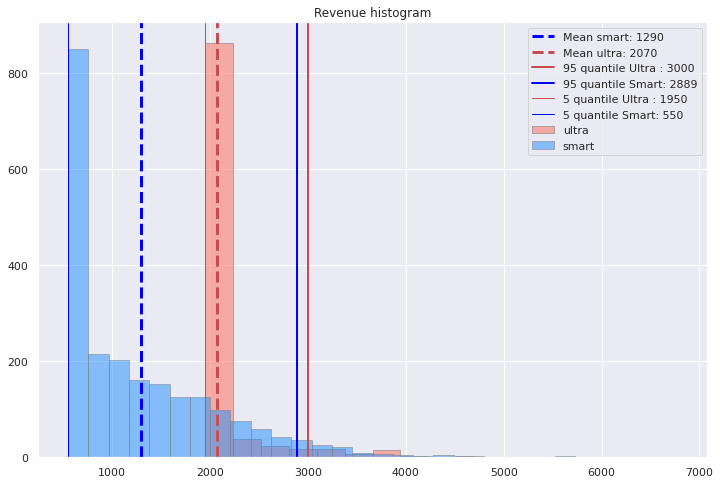

In [26]:
#ревьюер_код_ит
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.hist(ultra.revenue, bins=10, color='salmon', edgecolor='grey', alpha=0.6, label = 'ultra', density = False)
plt.hist(smart.revenue, bins=30, color='dodgerblue', edgecolor='grey', alpha=0.5,label = 'smart', density = False)

plt.axvline(smart.revenue.mean(), color='blue', linestyle='dashed', linewidth=3
                , label='Mean smart: {:.0f}'.format(smart.revenue.mean()))
plt.axvline(ultra.revenue.mean(), color='r', linestyle='dashed', linewidth=3
            , label='Mean ultra: {:.0f}'.format(ultra.revenue.mean()))
plt.axvline(np.quantile(ultra.revenue, 0.95), color='r', linestyle='solid', linewidth=2, 
            label='95 quantile Ultra : {:.0f}'.format(np.quantile(ultra.revenue, 0.95)))
plt.axvline(np.quantile(smart.revenue, 0.95), color='blue', linestyle='solid', linewidth=2, 
            label='95 quantile Smart: {:.0f}'.format(np.quantile(smart.revenue, 0.95)))
plt.axvline(np.quantile(ultra.revenue, 0.05), color='r', linestyle='solid', linewidth=1, 
            label='5 quantile Ultra : {:.0f}'.format(np.quantile(ultra.revenue, 0.05)))
plt.axvline(np.quantile(smart.revenue, 0.05), color='blue', linestyle='solid', linewidth=1, 
            label='5 quantile Smart: {:.0f}'.format(np.quantile(smart.revenue, 0.05)))
plt.legend()
plt.title('Revenue histogram')
plt.show()

## Шаг 4. Проверка гипотез
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### 4.1 Гипотеза о равенстве средних двух генеральных совокупностей: размер средней выручки от пользователей разных тарифов

* H1: выручка пользователей тарифов «Ультра» и «Смарт» различается
* H0: выручка пользователей тарифов «Ультра» и «Смарт» не различается

In [27]:
t_ultra = df_grouped_data.query('tariff == "ultra"')['revenue']
t_smart = df_grouped_data.query('tariff == "smart"')['revenue']

alpha = .05

result = st.ttest_ind(
    t_ultra, 
    t_smart)

print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Нулевая гипотеза отвергается")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4229814360764067e-160
Нулевая гипотеза отвергается


,revenue
tariff,
smart,"1,023.00"
ultra,"1,950.00"


,revenue
tariff,
smart,"2,875,351.00"
ultra,"2,039,100.00"


,revenue
tariff,
smart,2229
ultra,985


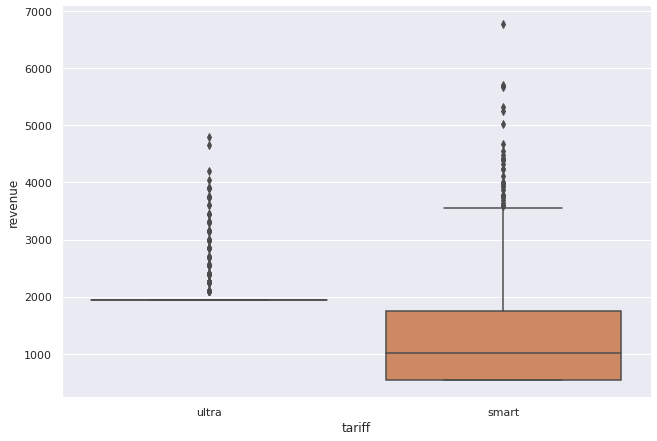

In [28]:
display(df_grouped_data.pivot_table(index='tariff', values='revenue', aggfunc='median'))
display(df_grouped_data.pivot_table(index='tariff', values='revenue', aggfunc='sum'))
display(df_grouped_data.pivot_table(index='tariff', values='revenue', aggfunc='count'))

_ = sns.catplot(x="tariff", y='revenue', kind="box", data=df_grouped_data, orient='v', height=6, aspect=1.5)

Разница по доходам на тарифах составляет практически два раза.
* Пользователи тарифа "Смарт" очевидно платят существенно больше тарифа потому что склонны экономить, но не планируют "вдолгую".
* Пользователи "Ультры" покупают пакетное предложение чтобы спокойно пользоваться тарифом и не отвлекаться на детали.
* Конечно же, пользователей тарифа "Ультра" будет существенно меньше. Оценка баланса между "бутиковой" и "розничной" стратегиями в данное задание не входит.

### 4.2 Гипотеза о равенстве средних двух генеральных совокупностей: размер средней выручки в Москве и регионах

* H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
* H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов

In [29]:
#добавим в сгрупированную таблицу название населенного пункта для каждого пользователя
###for user in df_grouped_data.index:
###    df_grouped_data.loc[user, 'city'] = df_users.loc[user[0]-1000, 'city']
display(df_grouped_data.head(10))

duration  calls  messages   mb_used tariff       city  revenue
user_id month                                                                
1000    5        159.00  22.00     22.00  3,072.00  ultra  Краснодар 1,950.00
        6        172.00  43.00     60.00 23,552.00  ultra  Краснодар 1,950.00
        7        340.00  47.00     75.00 14,336.00  ultra  Краснодар 1,950.00
        8        408.00  52.00     81.00 14,336.00  ultra  Краснодар 1,950.00
        9        466.00  58.00     57.00 15,360.00  ultra  Краснодар 1,950.00
        10       350.00  57.00     73.00 15,360.00  ultra  Краснодар 1,950.00
        11       338.00  43.00     58.00 15,360.00  ultra  Краснодар 1,950.00
        12       333.00  46.00     70.00 10,240.00  ultra  Краснодар 1,950.00
1001    11       430.00  59.00      0.00 18,432.00  smart     Москва 1,150.00
        12       414.00  63.00      0.00 14,336.00  smart     Москва   550.00

In [30]:
t_moscow = df_grouped_data.query('city == "Москва"')['revenue']
t_regions = df_grouped_data.query('city != "Москва"')['revenue']

alpha = .05

result = st.ttest_ind(
    t_moscow, 
    t_regions, 
    equal_var=False)

print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Нулевая гипотеза отвергается")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


,revenue
region,
Москва,"1,750.00"
Регионы,"1,583.00"


,revenue
region,
Москва,"945,042.00"
Регионы,"3,969,409.00"


,revenue
region,
Москва,611
Регионы,2603


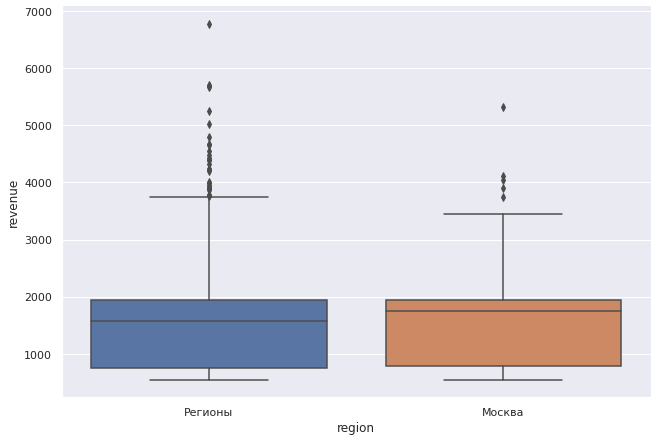

In [31]:
#напишем функцию для категоризаии населенных пунктов на категории столица - Москва и регионы 
def set_region(city):
    if city == 'Москва': return 'Москва'
    else: return 'Регионы'

df_grouped_data['region'] = df_grouped_data['city'].apply(set_region)

display(df_grouped_data.pivot_table(index='region', values='revenue', aggfunc='median'))
display(df_grouped_data.pivot_table(index='region', values='revenue', aggfunc='sum'))
display(df_grouped_data.pivot_table(index='region', values='revenue', aggfunc='count'))
    
_ = sns.catplot(x="region", y='revenue', kind="box", data=df_grouped_data, orient='v', height=6, aspect=1.5)

Гипотеза о различии средней выручки по тарифу в москве и регионах отвергается.
* Да, в Москве медианное значение выше примерно на 160 рублей, но это различие статистически не значимо.

## Общий вывод

<div class="alert alert-block alert-info">
</div>

* Все таблицы были успешно загружены, в данных нет пропусков и искажений
* Данные по пропущенным звонкам и нулевым сессиям данных соответсвуют методической сути явления и не требуют дополнительной обработки.
* В таблицы с данными по звонкам и интернет-траффику добавлена колонка с месяцем - требуется на последующих этапах.
* Проведено округление длительности звонков и интернет-траффика в большую сторону по логике тарифов.
* Для каждого пользователя вычислены:
    * количество сделанных звонков и израсходованных минут разговора по месяцам;
    * количество отправленных сообщений по месяцам;
    * объем израсходованного интернет-трафика по месяцам;
    * помесячная выручка с каждого пользователя.
* По каждому из тарифов:
    * Построена гистрграмма дохода на пользователя
    * Построены гистограммы распределения длительности звонков за месяц и боксплот активности пользователей по месяцам.
    * Построены гистограммы распределения объёма интернет-траффика за месяц и боксплот интернет-активности пользователей по месяцам.
* Проверены статистические гипотезы о равенстве средней выручки между тарифами и между москвой и регионами.

Выводы:
* Разница по доходам на тарифах составляет практически два раза.
* Разница между средней выручкой по тарифам в Москве и регионах не выявлена.

В целом можно сказать следующее:
* Тариф "Смарт" привлекает более суетных и экономных людей, которые в итоге плятят больше ожидаемого. Эта категория пользователей эмоциональна, более склонна к смене тарифов и операторов, её необъодимо постянно привлекать и удерживать разными "фишками".
* Тариф "Ультра" привлекает платёжеспособных пользователей, предпочитающих предсказуемость и стабильность. Они не высчитывают копеечные выгоды. Данную категорию пользователей важно удерживать и не создавать для них стрессовые ситуации.
* Пользователей тарифа "Ультра" в два раза меньше, но они менее суетны и приносят соизмеримый объём выручки.
* Оценка баланса между "бутиковой" и "розничной" стратегиями в данное задание не входит, но в целом можно дать рекомендацию по сохранению баланса тарифов. Отказ от любого из тарифов нежелателен.